# Muppet recognizer

Loads a trained CNN model, and applies it to a set of images.

# Configuration and setup

In [20]:
# The model and weights to use. This is the base name, there should be a file
# echo for the model, params and labels in the directory.
MODEL_NAME  = "muppets-theano-face-bestof50.relu"

# Which input images to use for matching.
TEST_IMAGES = "images.reduced/"

# Matching parameters
SCAN_MIN_SIZE   = 32 # The minimum image subsection to attempt to match.
SCAN_STRIDE     = 4  # The stride to use when scanning the image.
SCAN_IMAGE_SIZE = 64 # The size of the image we need to feed into the CNN.

Bunch of includes, some of these could probably be pruned down.

In [2]:
import matplotlib
import matplotlib.pyplot  as plt
import matplotlib.cm      as cm
import matplotlib.image   as mpimg
import matplotlib.patches as patches
%matplotlib inline  

from PIL import Image

from collections import Counter

import cPickle as pickle
import os
import gc
import numpy as np
import theano
import lasagne

from lasagne import layers
from lasagne.updates import nesterov_momentum
from lasagne.updates import adam

from lasagne.nonlinearities import softmax, rectify
from nolearn.lasagne import NeuralNet
from nolearn.lasagne import visualize
from nolearn.lasagne import PrintLayerInfo
from nolearn.lasagne import BatchIterator

from nolearn.lasagne.visualize import draw_to_notebook
from nolearn.lasagne.visualize import plot_loss
from nolearn.lasagne.visualize import plot_conv_weights
from nolearn.lasagne.visualize import plot_conv_activity
from nolearn.lasagne.visualize import plot_occlusion
from nolearn.lasagne.visualize import plot_saliency

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

layer_info = PrintLayerInfo()

Using cuDNN version 5005 on context None
Mapped name None to device cuda: Graphics Device (0000:05:00.0)
Using cuDNN version 5005 on context dev0
Mapped name dev0 to device cuda0: Graphics Device (0000:05:00.0)
ERROR (theano.gpuarray): Could not initialize pygpu, support disabled
Traceback (most recent call last):
  File "/usr/local/lib/python2.7/dist-packages/theano/gpuarray/__init__.py", line 175, in <module>
    init_dev(d.strip(), n.strip())
  File "/usr/local/lib/python2.7/dist-packages/theano/gpuarray/__init__.py", line 60, in init_dev
    sched=config.gpuarray.sched)
  File "pygpu/gpuarray.pyx", line 614, in pygpu.gpuarray.init (pygpu/gpuarray.c:9415)
  File "pygpu/gpuarray.pyx", line 566, in pygpu.gpuarray.pygpu_init (pygpu/gpuarray.c:9106)
  File "pygpu/gpuarray.pyx", line 1021, in pygpu.gpuarray.GpuContext.__cinit__ (pygpu/gpuarray.c:13468)
GpuArrayException: Unknown device error: 1
/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: Thi

# Load in a model

In [3]:
def load_neural_network(model_name):
    model_file = '%s.model.pickle'  % model_name
    param_file = '%s.params.pickle' % model_name
    label_file = '%s.labels.pickle' % model_name
    
    # Load the class labels.
    f = open(label_file, 'r')
    class_labels = pickle.load(f)
    f.close()
    
    # Load the layer configuration.
    f = open(model_file, 'r')
    layers = pickle.load(f)
    f.close()
    
    # Load the weights.
    f = open(param_file, 'r')
    param_values = pickle.load(f)
    f.close()
    
    # Now construct the NeuralNet object.
    neural_net = NeuralNet(
        layers = layers,
    
        # optimization method params
        update=adam,
        update_learning_rate=0.0002,
    
        objective_l2=0.0025,

        max_epochs=50,
        verbose=1,
    )
    
    neural_net.initialize()
    lasagne.layers.set_all_param_values(neural_net.layers_[-1], param_values)
    
    return (neural_net, class_labels)

In [4]:
(neural_net, class_labels) = load_neural_network(MODEL_NAME)

In [5]:
layer_info(neural_net)

# Neural Network with 9627795 learnable parameters

## Layer information

  #  name         size
---  -----------  ---------
  0  input0       3x64x64
  1  conv2d1      128x64x64
  2  conv2d2      128x64x64
  3  conv2d3      128x64x64
  4  conv2d4      128x64x64
  5  maxpool2d5   128x32x32
  6  conv2d6      128x32x32
  7  conv2d7      128x32x32
  8  conv2d8      128x32x32
  9  conv2d9      128x32x32
 10  maxpool2d10  128x16x16
 11  dense11      256
 12  dense12      256
 13  dropout13    256
 14  dense14      256
 15  dense15      256
 16  dense16      19



# Load in the images we're going to test with.

In [6]:
def load_images(base_path):
    X            = []
    y            = []
    class_labels = {}
    
    for subdir, dirs, files in os.walk(base_path):
        for file in files:
            file_path  = os.path.join(subdir, file)
            image      = Image.open(file_path)
            class_name = os.path.dirname(file_path).replace(base_path, '', 1)
            
            if not class_name in class_labels:
                class_labels[class_name] = len(class_labels)
                
            X.append(image)
            y.append(class_labels[class_name])
    
    class_labels_inverted = {v: k for k, v in class_labels.iteritems()}

    y = np.array(y)
    return (X, y, class_labels_inverted)

In [7]:
X_test, y_test, test_class_labels = load_images(TEST_IMAGES)

# Generate the scans of a single image.

Takes in a single image, and returns a list of image subsections, all scaled to the target size.

In [8]:
def get_image_scans(input_image, scan_size, scan_stride):
    image_scans = []
    scan_boxes  = []
    
    # print "Scanning at size %d, stride %d" % (scan_size, scan_stride)
    
    if (input_image.width < scan_size or input_image.height < scan_size):
        new_width   = max(input_image.width,  scan_size)
        new_height  = max(input_image.height, scan_size)
        
        # print "Rescaling image to %d, %d" % (new_width, new_height)
        
        normalized_image = Image.new("RGB", [scan_size, scan_size])
        x                = (scan_size - input_image.width)  / 2
        y                = (scan_size - input_image.height) / 2
        normalized_image.paste(input_image, box=(x, y))
        
        input_image = normalized_image
    
    for x in range(0, input_image.width - scan_size + 1, scan_stride):
        for y in range(0, input_image.height - scan_size + 1, scan_stride):
            scan_box = (x, y, x + scan_size, y + scan_size)
            scan     = input_image.crop(box=scan_box)
            scan     = scan.resize((SCAN_IMAGE_SIZE, SCAN_IMAGE_SIZE))
            
            image_scans.append(np.asarray(scan))
            scan_boxes.append(scan_box)
            
    # print "Generated %d sub-images" % len(image_scans)
    return (image_scans, scan_boxes)
    
def scan_image(input_image):
    image_scans = []
    scan_boxes  = []
    
    cur_scan_size = SCAN_MIN_SIZE
    max_scan_size = max(input_image.width, input_image.height)
    
    while True:
        (new_image_scans, new_scan_boxes) = get_image_scans(input_image, cur_scan_size, SCAN_STRIDE)
        image_scans += new_image_scans
        scan_boxes  += new_scan_boxes
        
        if (cur_scan_size >= max_scan_size):
            break
        
        cur_scan_size = min(max_scan_size, int(cur_scan_size * 1.5))
    
    return (np.array(image_scans).transpose((0,3,1,2)), scan_boxes)

# Now loop across the images and try to match them.

In [26]:
def match_image(image, label, plot_matches=False):
    (scans, boxes) = scan_image(image)
    preds          = neural_net.predict(scans)
    counts         = Counter(preds)
    top3           = counts.most_common(4)
    
    if class_labels[top3[0][0]] != 'background':
        print "Background wasn't the most popular!"
        
    background_percent = 100.0 * float(top3[0][1])    / len(scans)
    target_percent     = 100.0 * float(counts[label]) / len(scans)
    
    print "Image of %s: %0.2f%% background, %0.2f%% correct (%s)" % (class_labels[label], 
                                                                background_percent, 
                                                                target_percent,
                                                                "yes" if top3[1][0] == label else "no")

    if len(top3) > 1 and len(top3) < 3:
        print "Top 1 matches: %s (%d)" % (class_labels[top3[1][0]], top3[1][1])
    elif len(top3) < 4:
        print "Top 2 matches: %s (%d), %s (%d)" % (class_labels[top3[1][0]], top3[1][1],
                                                   class_labels[top3[2][0]], top3[2][1])
    else:
        print "Top 3 matches: %s (%d), %s (%d), %s (%d)" % (
                                                      class_labels[top3[1][0]], top3[1][1],
                                                      class_labels[top3[2][0]], top3[2][1],
                                                      class_labels[top3[3][0]], top3[3][1])
    
    if not plot_matches:
        return
    
    # Create figure and axes
    fig,ax = plt.subplots(1)

    # Display the image
    ax.imshow(image)

    for i in range(len(preds)):
        if (preds[i] == label):
            print "Box (%d, %d, %d, %d) matches" % boxes[i]
            color = 'r'
        elif (preds[i] == top3[1][0]):
            color = 'b'
        elif (preds[i] == top3[2][0]):
            color = 'g'
        else:
            continue
                    
        # Create a Rectangle patch
        rect = patches.Rectangle((boxes[i][0],boxes[i][1]), 
                                 boxes[i][2] - boxes[i][0], 
                                 boxes[i][3] - boxes[i][1], linewidth=1, edgecolor=color, facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.show()

Image of cookie_monster: 95.78% background, 2.86% correct (yes)
Top 3 matches: cookie_monster (38), rizzo_the_rat (6), grover (6)
Box (24, 76, 56, 108) matches
Box (32, 68, 64, 100) matches
Box (32, 72, 64, 104) matches
Box (32, 76, 64, 108) matches
Box (48, 20, 80, 52) matches
Box (48, 88, 80, 120) matches
Box (52, 16, 84, 48) matches
Box (60, 16, 92, 48) matches
Box (64, 16, 96, 48) matches
Box (68, 16, 100, 48) matches
Box (16, 64, 64, 112) matches
Box (16, 68, 64, 116) matches
Box (16, 72, 64, 120) matches
Box (20, 56, 68, 104) matches
Box (20, 60, 68, 108) matches
Box (24, 72, 72, 120) matches
Box (28, 68, 76, 116) matches
Box (28, 72, 76, 120) matches
Box (44, 12, 92, 60) matches
Box (48, 12, 96, 60) matches
Box (48, 16, 96, 64) matches
Box (52, 12, 100, 60) matches
Box (52, 16, 100, 64) matches
Box (56, 12, 104, 60) matches
Box (56, 16, 104, 64) matches
Box (4, 36, 76, 108) matches
Box (4, 40, 76, 112) matches
Box (8, 40, 80, 112) matches
Box (8, 44, 80, 116) matches
Box (12, 40

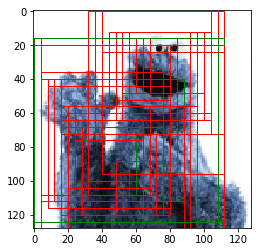

In [29]:
match_image(X_test[125], y_test[125], True)

In [22]:
for image, label in zip(X_test, y_test):
    match_image(image, label)

Image of count: 79.29% background, 2.48% correct (no)
Top 3 matches: rowlf_the_dog (154), count (33), rizzo_the_rat (26)
Image of count: 86.82% background, 0.83% correct (no)
Top 3 matches: rowlf_the_dog (39), rizzo_the_rat (32), miss_piggy (28)
Image of count: 79.67% background, 2.48% correct (no)
Top 3 matches: rowlf_the_dog (77), rizzo_the_rat (45), count (33)
Image of count: 81.93% background, 0.45% correct (no)
Top 3 matches: beaker (65), miss_piggy (42), rizzo_the_rat (36)
Image of count: 80.72% background, 0.75% correct (no)
Top 3 matches: rowlf_the_dog (55), rizzo_the_rat (38), oscar_the_grouch (27)
Image of count: 85.24% background, 1.36% correct (no)
Top 3 matches: rowlf_the_dog (57), rizzo_the_rat (38), miss_piggy (26)
Image of count: 90.74% background, 1.36% correct (no)
Top 3 matches: rizzo_the_rat (30), count (18), miss_piggy (18)
Image of count: 88.40% background, 0.75% correct (no)
Top 3 matches: miss_piggy (44), rowlf_the_dog (38), rizzo_the_rat (17)
Image of count: 79

# Scratch area

In [37]:
X0_scans = scan_image(X_test[0])

Scanning at size 32, stride 4
Generated 625 sub-images
Scanning at size 64, stride 4
Generated 289 sub-images
Scanning at size 128, stride 4
Generated 1 sub-images


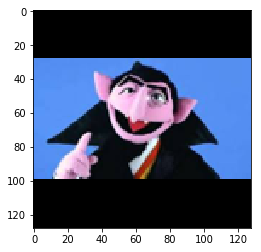

In [38]:
plt.imshow(X_test[0])

In [39]:
len(X0_scans)

915

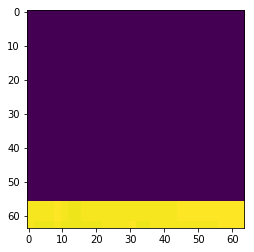

In [40]:
plt.imshow(X0_scans[100][0])

In [47]:
preds = neural_net.predict(X0_scans)

In [13]:
print class_labels
print test_class_labels

{0: 'count', 1: 'rowlf_the_dog', 2: 'bert', 3: 'gonzo', 4: 'cookie_monster', 5: 'big_bird', 6: 'oscar_the_grouch', 7: 'fozzie_bear', 8: 'beaker', 9: 'scooter', 10: 'elmo', 11: 'rizzo_the_rat', 12: 'ernie', 13: 'miss_piggy', 14: 'animal', 15: 'kermit_the_frog', 16: 'swedish_chef', 17: 'grover'}
{0: 'count', 1: 'rowlf_the_dog', 2: 'bert', 3: 'gonzo', 4: 'cookie_monster', 5: 'big_bird', 6: 'oscar_the_grouch', 7: 'fozzie_bear', 8: 'beaker', 9: 'scooter', 10: 'elmo', 11: 'rizzo_the_rat', 12: 'ernie', 13: 'miss_piggy', 14: 'animal', 15: 'kermit_the_frog', 16: 'swedish_chef', 17: 'grover'}


In [48]:
print preds
print len(preds)

[16  4  4  4  4  4  4  4  4  4  4  4 17 17 17  3  3  3  0  0  0  1  1  1  1
 16  4  4  4  4  4  4  4  4  4  4 17 17 17  3  3  3  3  0  0  0  1  1  1  1
 16  4  4  4  4  4  4  4  4  4  4 17 17  3  3  3  3  3  0  0  1  1  1  1 13
 16  4  4  4  4  4  4  4  4  4 17 17 17  3  3  3  3  0  0  0  1  1  1  1  1
 16  4  4  3  4  4  4  4  4  4  4 17 17  3  3  3  0  3  0  0  0  1  1  1  1
 16  4  4  3  3 17 17 17  4  4  4  4 17  4  3  3  0  3  0  0  1  1  1  1  1
 16  4  4  3  3  3 17  3  3  3  4  4  4  4  4  4 17  0  0  1  1  4  1  1  1
 16  4  4  3  3  3  3  3  3  3  0  4  4  3 11  4  4  0  1  1  1  1  1  1  1
 16  4  4  3  3  3  3 16  0  0  3  3  0  3 11 11  4  4  1  1  1  0  1  1 13
 16  4  4  3  3  3  3  3  8  0  3  3  0  3 11 11  3  4 11  0  4  1  1 17 13
 16  4  4  3  3  3  3  3  8  0  3  3  0  0 11  3  3 11 11  0  1  1 11 13 13
 16  4  4  3  3  3  3  3  3  0  0  3  3 16 11  8  0  0 13  1  1 11 11 13 13
 16  4  4  3  3  3  3  3  3  3  0 13  3  3 11  8  0  3 13  1 11  1  1  8  8
 16  4  4  3

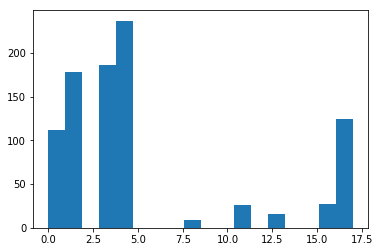

In [49]:
plt.hist(preds, len(test_class_labels))
plt.show()

In [44]:
output_layer = layers.get_output(neural_net.layers_['dense14'], deterministic=True)
input_var = neural_net.layers_['input0'].input_var
f_output = theano.function([input_var], output_layer)

<Container object of 18 artists>

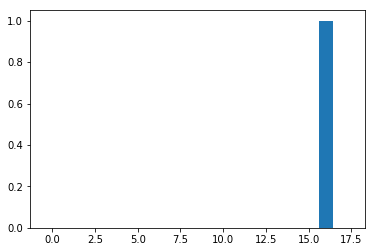

In [50]:
instance = X0_scans[100][None, :, :]
pred = f_output(instance)
N = pred.shape[1]
plt.bar(range(N), pred.ravel())